In [3]:
import pandas as pd
import torch

In [4]:
df = pd.read_pickle("/filserver/tide-hackaton/datasets/Disinformation-challenge-data/twitter/twitter_combined_df.pickle")

In [5]:
embeddings = torch.load("/filserver/tide-hackaton/datasets/Disinformation-challenge-data/twitter/twitter_combined_SimCSE_embeddings_normalized.pt")

# Clustering

In [4]:
from sklearn.cluster import MiniBatchKMeans

In [5]:
num_clusters = 4
clusterer = MiniBatchKMeans(n_clusters=num_clusters, batch_size=1024, random_state=0, n_init="auto", verbose=0)
cluster_allocations = clusterer.fit_predict(embeddings)

## Show cluster examples

In [ ]:
examples_per_cluster = 6

# Show examples for each cluster, but at most for 6 clusters.
for cluster in range(min(6, num_clusters)):
    print("Cluster number", cluster)
    cluster_texts = df[cluster_allocations == cluster]
    print("Number of items in this cluster:", len(cluster_texts))
    example_texts = cluster_texts.sample(examples_per_cluster)
    print()

    for text in example_texts["content_wo_hashtags"]:
        print(text)
        print("---")
    print("\n========\n")

# Dimensionality reduction

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
# pca = PCA(n_components=2)
# pca.fit(embeddings.numpy())
# embeddings_pca = pca.transform(embeddings.numpy())

In [6]:
import pickle

In [ ]:
# with open("/filserver/tide-hackaton/models/pca_2d_tweets.pickle", "wb") as f:
#     pickle.dump(pca, f)

In [20]:
with open("/filserver/tide-hackaton/models/pca_2d_tweets.pickle", "rb") as f:
    pca = pickle.load(f)
embeddings_pca = pca.transform(embeddings)

In [37]:
dim_reduced_embeddings = torch.load("/filserver/tide-hackaton/datasets/Disinformation-challenge-data/twitter/twitter_combined_SimCSE_embeddings_normalized_tsne-reduced.pt")

In [19]:
from matplotlib import pyplot as plt

In [ ]:
dim_reduced_embeddings

In [9]:
def hashtags2color(hashtags):
    if isinstance(hashtags, float):
        return "gray"
    if "StandWithUkraine" in hashtags:
        return "orange"
    if "BidenIsALaughingstock" in hashtags:
        return "green"
    return "blue"

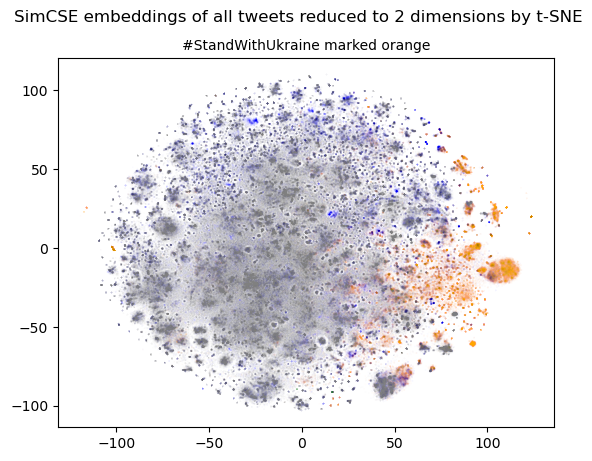

In [26]:
plt.scatter(x=dim_reduced_embeddings[:, 0], y=dim_reduced_embeddings[:, 1], s=0.1, alpha=0.02, c=df["hashtags"].map(hashtags2color))
plt.suptitle("SimCSE embeddings of all tweets reduced to 2 dimensions by t-SNE")
plt.title("#StandWithUkraine marked orange", fontdict={"size":10})
plt.show()

In [10]:
import numpy as np

In [14]:
border_a = 1.6
border_b = -0.27
border_xs = np.linspace(-0.2, 0.5, 20)
border_ys = border_a * border_xs + border_b

# line: y = a*x + b
# a*x - 1*y + b = 0
# signed distance from line: (a*x - y + b) / sqrt(a**2 + 1**2)

distance_from_line = (border_a*embeddings_pca[:, 0] - embeddings_pca[:, 1] + border_b) / (border_a**2 + 1)**0.5
distance_from_line

array([-0.11769254, -0.24592689, -0.35526629, ..., -0.28043792,
       -0.24389065, -0.15158919])

In [15]:
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2  # Reload imported libraries to avoid restarting kernel if they are modified.
from models.classifiers.SimpleRusUkrWarRelevanceClassifier import SimpleRusUkrWarRelevanceClassifier
susclf = SimpleRusUkrWarRelevanceClassifier()

Finner ledige GPU-er…
Det fins 8 GPU-er. Sjekker nr. 0, 1, 2, 3, 4, 5, 6, 7, 
Ubrukte GPU-er: [0, 1, 2, 3, 4, 7]
Valgte enhet cuda:7.


In [16]:
df_subset = df.sample(1000)
df_subset_embeddings_pca = embeddings_pca[df_subset.index]
ukrainesupportscores = susclf.predict(list(df_subset["content_wo_hashtags"]))
ukrainesupportscores = ukrainesupportscores["confs"][:, 0]
# display(ukrainesupportscores)

100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


In [ ]:
display(ukrainesupportscores)

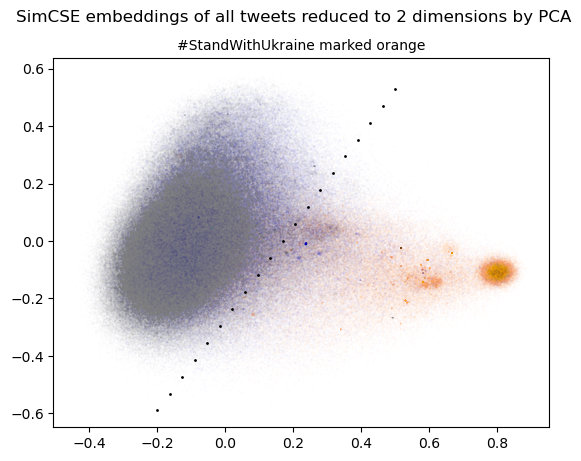

In [25]:
plt.scatter(x=embeddings_pca[:, 0], y=embeddings_pca[:, 1], s=0.1, alpha=0.02, c=df["hashtags"].map(hashtags2color))
plt.scatter(x=border_xs, y=border_ys, c="black", s=1)
# plt.scatter(x=df_subset_embeddings_pca[:, 0], y=df_subset_embeddings_pca[:, 1], c=ukrainesupportscores>0.5)
plt.suptitle("SimCSE embeddings of all tweets reduced to 2 dimensions by PCA")
plt.title("#StandWithUkraine marked orange", fontdict={"size":10})
plt.show()

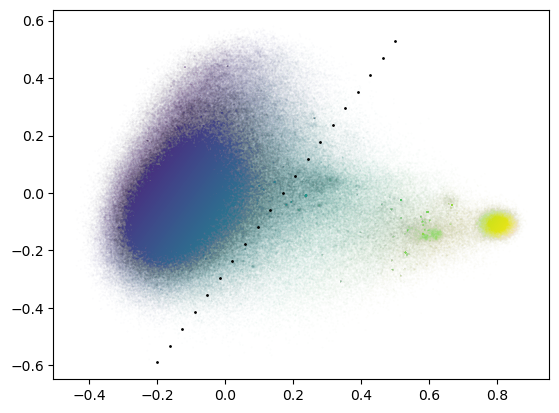

In [19]:
plt.scatter(x=embeddings_pca[:, 0], y=embeddings_pca[:, 1], s=0.1, alpha=0.02, c=np.tanh(1*distance_from_line))
plt.scatter(x=border_xs, y=border_ys, c="black", s=1)
plt.show()

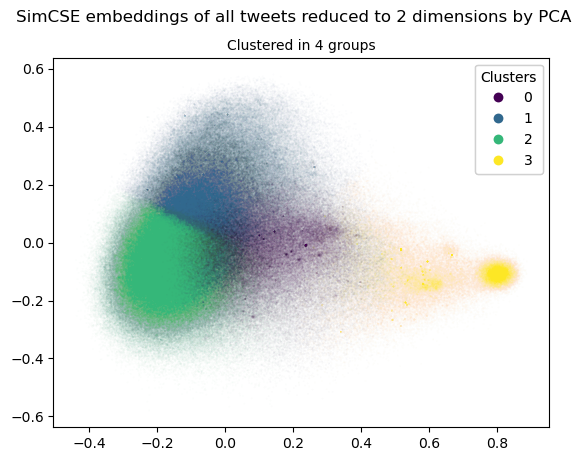

In [28]:
fig, ax = plt.subplots()

scatter = ax.scatter(x=embeddings_pca[:, 0], y=embeddings_pca[:, 1], s=0.1, alpha=0.02, c=cluster_allocations)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
for lh in legend1.legendHandles: 
    lh.set_alpha(1)
ax.add_artist(legend1)
plt.suptitle("SimCSE embeddings of all tweets reduced to 2 dimensions by PCA")
plt.title("Clustered in 4 groups", fontdict={"size":10})

# plt.scatter(x=embeddings_pca[:, 0], y=embeddings_pca[:, 1], s=0.1, alpha=0.02, c=cluster_allocations)
plt.show()

# Hand annotated dataset

In [8]:
with open("/filserver/tide-hackaton/datasets/Disinformation-challenge-data/twitter/misinformation_train.txt", "rb") as f:
    disinformation_ids = f.readlines()
disinformation_ids = [int(line) for line in disinformation_ids]

In [9]:
disinfo_tweets = df[df["id"].isin(disinformation_ids)]

In [10]:
disinfo_tweets.head(2)

,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,content_wo_hashtags,username,description,created,followersCount,friendsCount,statusesCount,favouritesCount,account_age,content_simplified
304,snscrape.modules.twitter.Tweet,https://twitter.com/chromedude1/status/1500157...,2022-03-05 17:12:55+00:00,@Kenny_Wallace Ukraine is Money laundering hub...,@Kenny_Wallace Ukraine is Money laundering hub...,1500157422010257411,"{'_type': 'snscrape.modules.twitter.User', 'us...",13,5,54,...,@Kenny_Wallace Ukraine is Money laundering hub...,chromedude1,I cuss. ALOT. You’ve been warned. Known to som...,2021-02-26T00:27:26+00:00,171,227,4033,1230,372,kenni wallac ukrain money launder hub corrupt ...
2673,snscrape.modules.twitter.Tweet,https://twitter.com/NunNun000000/status/149944...,2022-03-03 17:57:46+00:00,@GeorgeToumanof @jordanbpeterson The US invade...,@GeorgeToumanof @jordanbpeterson The US invade...,1499443933167898627,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,1,...,@GeorgeToumanof @jordanbpeterson The US invade...,NunNun000000,,2021-11-15T20:06:25+00:00,24,47,830,4192,107,georgetoumanof jordanbpeterson us invad ukrain...


In [12]:
disinfo_tweets_embeddings = embeddings[disinfo_tweets.index]
display(disinfo_tweets_embeddings)

tensor([[-0.0020, -0.0409, -0.0376,  ..., -0.0042,  0.0031,  0.0048],
        [ 0.0176, -0.0399, -0.0507,  ..., -0.0016,  0.0220, -0.0261],
        [ 0.0251, -0.0314, -0.0593,  ..., -0.0100, -0.0092,  0.0281],
        ...,
        [ 0.0281, -0.0316, -0.0449,  ..., -0.0320,  0.0059,  0.0015],
        [ 0.0500, -0.0049, -0.0578,  ..., -0.0292,  0.0269,  0.0042],
        [ 0.0286, -0.0343, -0.0474,  ..., -0.0187, -0.0144, -0.0226]],
       dtype=torch.float16)

In [ ]:
disinfo_tweets_embeddings_pca = pca.transform(disinfo_tweets_embeddings)
display(disinfo_tweets_embeddings_pca[:4])

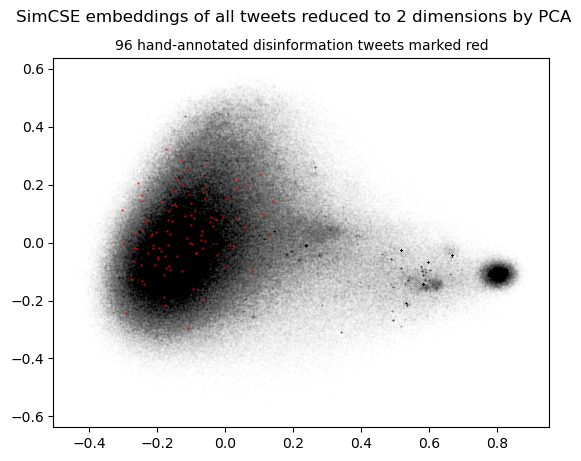

In [29]:
plt.scatter(x=embeddings_pca[:, 0], y=embeddings_pca[:, 1], s=0.1, alpha=0.02, c="black")
plt.scatter(x=disinfo_tweets_embeddings_pca[:, 0], y=disinfo_tweets_embeddings_pca[:, 1], s=0.8, alpha=0.5, c="red")
# plt.scatter(x=df_subset_embeddings_pca[:, 0], y=df_subset_embeddings_pca[:, 1], c=ukrainesupportscores>0.5)
plt.suptitle("SimCSE embeddings of all tweets reduced to 2 dimensions by PCA")
plt.title("96 hand-annotated disinformation tweets marked red", fontdict={"size":10})
plt.show()

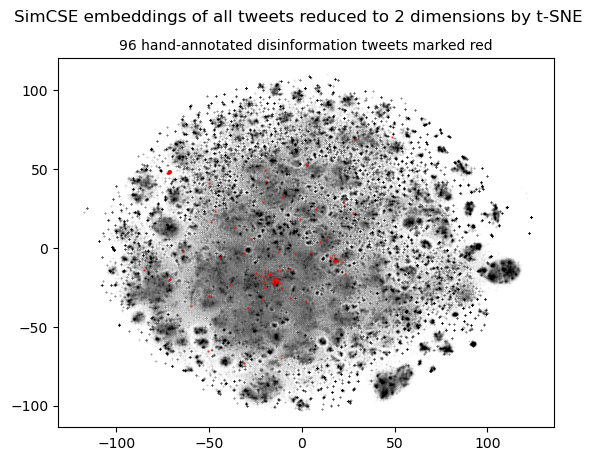

In [31]:
disinfo_tweets_embeddings_tsne = dim_reduced_embeddings[disinfo_tweets.index]

plt.scatter(x=dim_reduced_embeddings[:, 0], y=dim_reduced_embeddings[:, 1], s=0.1, alpha=0.02, c="black")
plt.scatter(x=disinfo_tweets_embeddings_tsne[:, 0], y=disinfo_tweets_embeddings_tsne[:, 1], s=0.8, alpha=0.5, c="red")

plt.suptitle("SimCSE embeddings of all tweets reduced to 2 dimensions by t-SNE")
plt.title("96 hand-annotated disinformation tweets marked red", fontdict={"size":10})
plt.show()

In [13]:
from sklearn.linear_model import LogisticRegression

In [31]:
print(disinfo_tweets_embeddings.shape[0])
print(negative_embeddings.shape[0])

print(logreg_sampleweight_pos)
print(logreg_sampleweight_neg)

78
1000
13.820512820512821
1.078


In [ ]:
display(logreg_sampleweights)

In [30]:
negative_samples_indexes = df[~df["id"].isin(disinformation_ids)].sample(1000).index
negative_embeddings = embeddings[negative_samples_indexes]

logreg_X = torch.concat((disinfo_tweets_embeddings, negative_embeddings))
logreg_y = [1] * disinfo_tweets_embeddings.shape[0] + [0] * negative_embeddings.shape[0]

logreg_sampleweight_pos = logreg_X.shape[0] / disinfo_tweets_embeddings.shape[0]
logreg_sampleweight_neg = logreg_X.shape[0] / negative_embeddings.shape[0]
logreg_sampleweights = [logreg_sampleweight_pos] * disinfo_tweets_embeddings.shape[0] + [logreg_sampleweight_neg] * negative_embeddings.shape[0]

logregclf = LogisticRegression(verbose=1, n_jobs=32)
logregclf.fit(X=logreg_X, y=logreg_y, sample_weight=logreg_sampleweights)

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1025     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49443D+03    |proj g|=  1.59386D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1025     34     38      1     0     0   5.673D-04   5.205D+02
  F =   520.52297415275814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    3.5s finished


LogisticRegression(n_jobs=32, verbose=1)

In [32]:
logreg_scores_for_all_tweets = logregclf.predict_proba(embeddings)

In [36]:
logreg_scores_for_all_tweets

array([[0.53351141, 0.46648859],
       [0.54360807, 0.45639193],
       [0.93890785, 0.06109215],
       ...,
       [0.90489119, 0.09510881],
       [0.87789529, 0.12210471],
       [0.93249305, 0.06750695]])

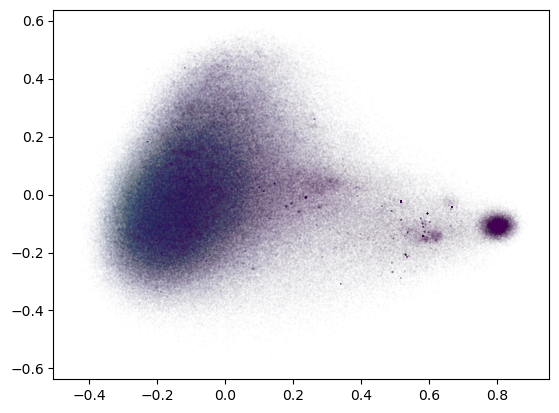

In [35]:
plt.scatter(x=embeddings_pca[:, 0], y=embeddings_pca[:, 1], s=0.1, alpha=0.02, c=logreg_scores_for_all_tweets[:, 1])
# plt.suptitle("SimCSE embeddings of all tweets reduced to 2 dimensions by PCA")
# plt.title("96 hand-annotated disinformation tweets marked red", fontdict={"size":10})
plt.show()

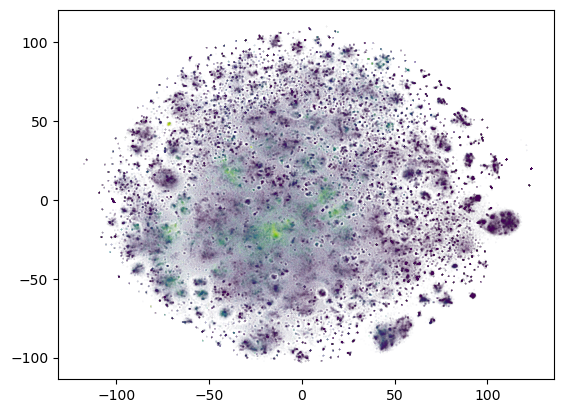

In [38]:
plt.scatter(x=dim_reduced_embeddings[:, 0], y=dim_reduced_embeddings[:, 1], s=0.1, alpha=0.02, c=logreg_scores_for_all_tweets[:, 1])
# plt.suptitle("SimCSE embeddings of all tweets reduced to 2 dimensions by t-SNE")
# plt.title("#StandWithUkraine marked orange", fontdict={"size":10})
plt.show()

## Save LogisticRegression object

In [41]:
# with open("/filserver/tide-hackaton/models/misinf_simcse_linear_logregobj.pickle", "wb") as f:
#     pickle.dump(logregclf, f)